<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BTeresina%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://raw.githubusercontent.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/master/DadosDiarios/teresinadiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,20498.0,20498.000000,9943.000000,10153.000000,9490.000000,9713.00000,8192.000000,8673.000000,7858.000000,8899.000000,0.0
mean,82578.0,600.117085,3.490224,34.112518,22.439515,8.00698,4.647266,27.426817,72.263076,1.424951,NaN
std,0.0,600.014625,10.286117,2.573680,1.566872,2.87235,3.613942,1.636598,13.398134,0.682443,NaN
min,82578.0,0.000000,0.000000,23.800000,10.400000,0.00000,0.000000,22.020000,29.500000,0.000000,NaN
25%,82578.0,0.000000,0.000000,32.200000,21.600000,6.50000,2.000000,26.240000,61.750000,0.941666,NaN
50%,82578.0,1200.000000,0.000000,33.800000,22.600000,9.00000,3.700000,27.140000,75.000000,1.333333,NaN
75%,82578.0,1200.000000,0.600000,36.200000,23.400000,10.20000,7.000000,28.560000,83.250000,1.833333,NaN
max,82578.0,1200.000000,125.000000,41.100000,27.500000,67.00000,26.600000,33.020000,100.000000,8.000000,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,82578,1980-01-01,0,NaN,31.8,NaN,5.0,1.7,26.84,85.00,0.966667,NaN
1,82578,1980-01-01,1200,9.6,NaN,23.3,NaN,NaN,NaN,NaN,NaN,NaN
2,82578,1980-01-02,0,NaN,33.6,NaN,7.8,2.1,27.28,74.75,0.766667,NaN
3,82578,1980-01-02,1200,0.0,NaN,23.5,NaN,NaN,NaN,NaN,NaN,NaN
4,82578,1980-01-03,0,NaN,28.5,NaN,0.2,3.3,25.48,85.00,1.566667,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,10153.000000,0.0,9713.00000,8192.000000,8673.000000,7858.000000,8899.000000
mean,NaN,34.112518,NaN,8.00698,4.647266,27.426817,72.263076,1.424951
std,NaN,2.573680,NaN,2.87235,3.613942,1.636598,13.398134,0.682443
min,NaN,23.800000,NaN,0.00000,0.000000,22.020000,29.500000,0.000000
25%,NaN,32.200000,NaN,6.50000,2.000000,26.240000,61.750000,0.941666
50%,NaN,33.800000,NaN,9.00000,3.700000,27.140000,75.000000,1.333333
75%,NaN,36.200000,NaN,10.20000,7.000000,28.560000,83.250000,1.833333
max,NaN,41.100000,NaN,67.00000,26.600000,33.020000,100.000000,8.000000


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,9943.000000,0.0,9490.000000,0.0,0.0,0.0,0.0,0.0
mean,3.490224,NaN,22.439515,NaN,NaN,NaN,NaN,NaN
std,10.286117,NaN,1.566872,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,10.400000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,21.600000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,22.600000,NaN,NaN,NaN,NaN,NaN
75%,0.600000,NaN,23.400000,NaN,NaN,NaN,NaN,NaN
max,125.000000,NaN,27.500000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,31.8,5.0,1.7,26.84,85.00,0.966667
1980-01-02,33.6,7.8,2.1,27.28,74.75,0.766667
1980-01-03,28.5,0.2,3.3,25.48,85.00,1.566667
1980-01-04,32.7,7.1,1.4,NaN,NaN,NaN
1980-01-05,31.5,2.4,3.2,25.84,81.00,1.866667


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,9.6,23.3
1980-01-02,0.0,23.5
1980-01-03,0.0,24.2
1980-01-04,0.0,22.8
1980-01-05,26.4,22.1


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,31.8,5.0,1.7,26.84,85.00,0.966667,9.6,23.3
1980-01-02,33.6,7.8,2.1,27.28,74.75,0.766667,0.0,23.5
1980-01-03,28.5,0.2,3.3,25.48,85.00,1.566667,0.0,24.2
1980-01-04,32.7,7.1,1.4,NaN,NaN,NaN,0.0,22.8
1980-01-05,31.5,2.4,3.2,25.84,81.00,1.866667,26.4,22.1


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,10153.000000,9713.00000,8192.000000,8673.000000,7858.000000,8899.000000,9943.000000,9490.000000
mean,34.112518,8.00698,4.647266,27.426817,72.263076,1.424951,3.490224,22.439515
std,2.573680,2.87235,3.613942,1.636598,13.398134,0.682443,10.286117,1.566872
min,23.800000,0.00000,0.000000,22.020000,29.500000,0.000000,0.000000,10.400000
25%,32.200000,6.50000,2.000000,26.240000,61.750000,0.941666,0.000000,21.600000
50%,33.800000,9.00000,3.700000,27.140000,75.000000,1.333333,0.000000,22.600000
75%,36.200000,10.20000,7.000000,28.560000,83.250000,1.833333,0.600000,23.400000
max,41.100000,67.00000,26.600000,33.020000,100.000000,8.000000,125.000000,27.500000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,31.8,5.0,1.7,26.84,85.00,0.966667,9.6,23.3
1980-01-02,33.6,7.8,2.1,27.28,74.75,0.766667,0.0,23.5
1980-01-03,28.5,0.2,3.3,25.48,85.00,1.566667,0.0,24.2
1980-01-04,32.7,7.1,1.4,NaN,NaN,NaN,0.0,22.8
1980-01-05,31.5,2.4,3.2,25.84,81.00,1.866667,26.4,22.1


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,5.0,1.7,26.84,85.00,0.966667,9.6,23.3
1980-01-02,7.8,2.1,27.28,74.75,0.766667,0.0,23.5
1980-01-03,0.2,3.3,25.48,85.00,1.566667,0.0,24.2
1980-01-04,7.1,1.4,NaN,NaN,NaN,0.0,22.8
1980-01-05,2.4,3.2,25.84,81.00,1.866667,26.4,22.1


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    31.8
1980-01-02    33.6
1980-01-03    28.5
1980-01-04    32.7
1980-01-05    31.5
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,9623.000000,8188.000000,8671.000000,7854.000000,8805.000000,9841.000000,9487.000000
mean,0.241162,-0.650606,-0.016874,0.213066,-0.449817,-0.944148,0.408075
std,0.434764,0.271736,0.297541,0.379998,0.262118,0.164256,0.183260
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.007752,-0.849624,-0.232727,-0.085106,-0.633205,-1.000000,0.309942
50%,0.395349,-0.721805,-0.069091,0.290780,-0.485200,-1.000000,0.426901
75%,0.581395,-0.473684,0.189091,0.524823,-0.292149,-0.990400,0.520468
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(10153, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 939.3503 - mean_absolute_error: 30.4735
Epoch 2/200
 - 1s - loss: 620.1936 - mean_absolute_error: 24.7329
Epoch 3/200
 - 1s - loss: 405.4493 - mean_absolute_error: 19.9296
Epoch 4/200
 - 1s - loss: 251.0034 - mean_absolute_error: 15.5891
Epoch 5/200
 - 1s - loss: 143.9019 - mean_absolute_error: 11.6695
Epoch 6/200
 - 1s - loss: 74.7579 - mean_absolute_error: 8.2022
Epoch 7/200
 - 1s - loss: 34.9070 - mean_absolute_error: 5.3006
Epoch 8/200
 - 1s - loss: 15.6551 - mean_absolute_error: 3.2236
Epoch 9/200
 - 1s - loss: 8.5842 - mean_absolute_error: 2.3026
Epoch 10/200
 - 1s - loss: 6.8593 - mean_absolute_error: 2.1462
Epoch 11/200
 - 1s -

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.231323, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.231323 (0.052401) {'batch_size': 10, 'camadas': 2, 'units': 7}


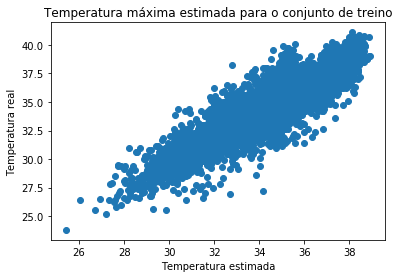

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.90690739]
 [0.90690739 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

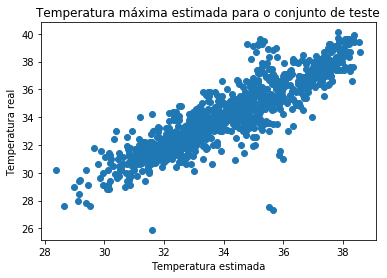

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.88904975]
 [0.88904975 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.827128455394835


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

1.3594868629595642


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,31.8,5.0,1.7,26.84,85.00,0.966667,9.6
1980-01-02,33.6,7.8,2.1,27.28,74.75,0.766667,0.0
1980-01-03,28.5,0.2,3.3,25.48,85.00,1.566667,0.0
1980-01-04,32.7,7.1,1.4,NaN,NaN,NaN,0.0
1980-01-05,31.5,2.4,3.2,25.84,81.00,1.866667,26.4


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    23.3
1980-01-02    23.5
1980-01-03    24.2
1980-01-04    22.8
1980-01-05    22.1
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,9487.000000,8964.000000,7720.000000,8503.000000,7234.000000,8153.000000,9182.000000
mean,0.191240,0.237261,-0.658175,-0.014294,0.174079,-0.453784,-0.943860
std,0.296914,0.436161,0.262816,0.298682,0.396197,0.262084,0.164362
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.028902,0.007752,-0.849624,-0.232727,-0.135338,-0.639640,-1.000000
50%,0.156069,0.379845,-0.725564,-0.065455,0.255639,-0.485200,-1.000000
75%,0.421965,0.581395,-0.481203,0.192727,0.496241,-0.305019,-0.988800
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(9490, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 368.9103 - mean_absolute_error: 19.0448
Epoch 2/200
 - 1s - loss: 194.8834 - mean_absolute_error: 13.8116
Epoch 3/200
 - 1s - loss: 98.7378 - mean_absolute_error: 9.7505
Epoch 4/200
 - 1s - loss: 44.1733 - mean_absolute_error: 6.3997
Epoch 5/200
 - 1s - loss: 17.0125 - mean_absolute_error: 3.8186
Epoch 6/200
 - 1s - loss: 6.1710 - mean_absolute_error: 2.1671
Epoch 7/200
 - 1s - loss: 3.0810 - mean_absolute_error: 1.4287
Epoch 8/200
 - 1s - loss: 2.5367 - mean_absolute_error: 1.2326
Epoch 9/200
 - 1s - loss: 2.4917 - mean_absolute_error: 1.2004
Epoch 10/200
 - 1s - loss: 2.4908 - mean_absolute_error: 1.1967
Epoch 11/200
 - 1s - loss: 2.4913 - mean_absolute_error: 1.1978
Epoch 12/200
 - 1s - loss: 2.4914 - mean_absolute_error: 1.1960
Epoch 13/200
 - 1s - 

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.063116, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.063116 (0.023707) {'batch_size': 10, 'camadas': 2, 'units': 7}


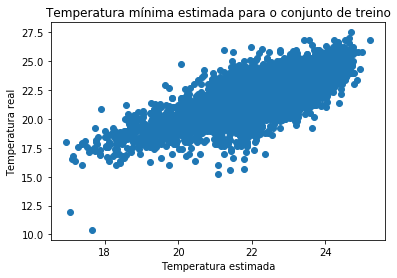

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.76310196]
 [0.76310196 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

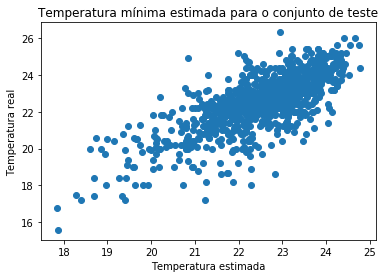

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.        0.7443131]
 [0.7443131 1.       ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.7733166930798611


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

1.053036170911901


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaTeresina.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaTeresina.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))